# Beginner's Deep Learning Guide

By: Francesco Civilini

This guide combines information from the following references:
- *fast.ai* Deep Learning course: https://course.fast.ai/
- Michael Nielson's *Neural Network and Deep Learning free online* book: http://neuralnetworksanddeeplearning.com
- José Fernández Portal's great way to look at Stochastic Gradiant Descent (Twitter: joshfp)
- Wikipedia

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from fastai.basics import *
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Articifial Neural Nets

Deep learning is a subset of machine learning based on the **universal approximation theorem**, which states that any function be resolved through a single hidden layer which produces a sum based on a linear and nonlinear operations on the inputs.

**Artificial Neural Networks** are systems which link together inputs, operations, and outputs. Each node is often called a neuron.

The example below describes an input data $x$, the importance or weight of the input $w$, an operation in the center with $b$ as the **bias** value, and an output.  

<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/images/1in_1hid.png" alt="Drawing" style="width: 300px;">

This can be overwhelming to think about, so let's tackle each parameter with a real-world comparison.

Let's say I'm trying to decide whether or not to go to the movies. The output is binary, I either go to the movies or not. This binary-output is called a **perceptron**. 

This single input-layer process is equivalent to the movie theater showing a single movie, let's say *The Avengers* by Marvel Studios. The weight $w$ corresponds to how much I want to see this movie. If I really like superhero movies, this weight $w$ may be large, and vice versa. If this combination (*The Avengers* with the weight $w$) is greater than a certain threshold (known as the bias $b$), then I will go to the movie theater. The operation node (or hidden layer) is where I do a computation of whether or not I want to go to the movies.  

Mathmatically, the first situation (movie theater only showing the avengers, can be thought of as the following (star represents the dot product):

$x_1 * w_1 >= b \implies output = 1 $  (we go to the movies)

$x_1 * w_1 < b  \implies output = 0 $  (we stay home)

or, more commonly:

$x_1 * w_1 - b >= 0 \implies output = 1 $  (we go to the movies)

$x_1 * w_1 - b < 0  \implies output = 0 $  (we stay home)

Now, let's pose a 2-movie problem, or a neural net with two input cells:

<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/images/2in_1hid.png" alt="Drawing" style="width: 300px;">

Maybe there are two movies showing at the movie theater. Alongside *The Avengers* (input $x_1$), the movie theater is also showing *A Dog's Purpose* (input $x_2$). Maybe I really hate superhero movies ($w_1$ is very small or negative), but I really love dogs ($w_2$ is very large) so it easily passes the threshold $b$. 

The second situation (movie theater showing *The Avengers* and *A Dog's Purpose*) will be:

$x_1 * w_1 + x_2 * w_2 - b >= 0 \implies output = 1 $  (we go to the movies)

$x_1 * w_1 + x_2 * w_2 - b < 0  \implies output = 0 $  (we stay home)

Working with weights and biases using percetrons can be quite tricky. This is because any slight changes to $w_1$ or $w_2$ can surpass our threshold in either direction. Instead, we want something that can be more precisely calibrated. Additionally, we would like to be able to quantify how much we want to go to the movies, not just say whether or not we want to go. This is where the **sigmoid neurons** come in. A sigmoid function is defined as:

$\sigma(z) = \frac{1}{1+e^{-z}}$


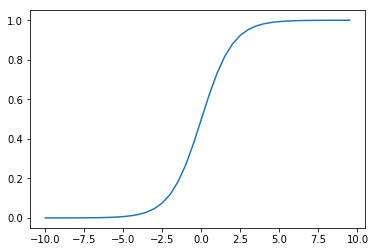

In [2]:
z = np.arange(-10,10,0.5)
sigma = []
for zval in z:
    sigma.append(1/(1+math.exp(-1*zval)))

plt.plot(z,sigma)

Looking at the first neural net we designed:

<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/images/1in_1hid.png" alt="Drawing" style="width: 300px;">

We can create a sigmoid neuron $\sigma(z)$ with $z = xw_1 + b$:

$\sigma(xw_1 + b) = \frac{1}{1+e^{-(xw_1 + b)}}$ 

Or the second example:

<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/images/2in_1hid.png" alt="Drawing" style="width: 300px;">

$\sigma(x_1w_1 + x_2w_2 + b) = \frac{1}{1+exp(-x_1w_1 - x_2w_2 - b)}$ 

Let's take a further look at the terms of the exponential function. Let's define a value $\alpha$.

$\alpha = x_1w_1 + x_2w_2$ 

In Neural Networks, we typically don't have singular values for inputs. Instead they contain a range of values in a category. If we keep our movie theater example, we could redefine the problem like this:

$x_1$ could represent the movies showing at the movie theater and $x_2$ represents the snacks available. In other words, $x_1$ and $x_2$ are really $\vec{x_1}$ and $\vec{x_2}$, vectors whose elements are the movies and snacks at the theater respectively. Maybe you're only slightly interested in the movies at playing, but you go to the movies anyways because *The Avengers* is good enough and you really want to eat some popcorn! 

So, we can rewrite $\alpha$ as:

$\alpha = \vec{x_1}w_1 + \vec{x_2}w_2 = X\vec{w}$

where $X$ is an array whose columns are the numbers of parameters (movies and snacks) and the rows are the elements in each set. The weights are in vector $\vec{w} = [w_1, w_2]$

We can now generalize our sigmoid function:

$\sigma(X\vec{w} + b) = \frac{1}{1+exp(-X\vec{w} - b)}$ 


# Stochastic Gradient Descent

Ok, so we have our generalized equation for our hidden layers. We briefly described that the reason we use sigmoid function is to be able to slightly change the weights. How do we do this in practice?

The process is called **Stochastic Gradient Descrent**. Sounds fancy, but all it means is pick random values for the weights, take a bunch of derivatives on a measure of error, then redo the whole process several times.

We are going to need a more concrete example than the movie theater though. We shall use the example described in *Fast.ai*'s Deep Learning Course Lesson 2 (and lift most of their codes - Go through their MOOC for that lesson if you have time, it's very good).

**Note:** Most of the following code requires the PyTorch Python package. I've run this problem using the GPU for computation (default), but the computations are small enough to be run via a CPU.

Assume that you have a set of points, and you're trying to find the best fit line that goes through them:

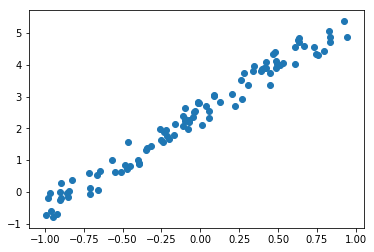

In [3]:
# The number of points we will be using. 
n = 100

# Set up a PyTorch vector where of size n,2
# The function torch.ones() automatically converts it to tensor format. 
x = torch.ones(n,2) 

# Set x1 to be a bunch of random points between -1 to 1. This will be the points of our independent variable. 
x[:,0].uniform_(-1.,1)

# This is the bet fit slope we will try to find later
a_sol = tensor(3.,2.)

# We multiply the array with the solution, and then add some noise
y = x@a_sol + torch.rand(n)

plt.scatter(x[:,0], y)

The equation of a line is $y = mx + b$, where $m$ is the slope and $b$ is the y-intercept. We can rewrite our expression as:

$y = x_1w_1 + x_2w_2$ where $x_2 = 1$

Hopefully, this looks familiar. We're back to this:

<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/images/2in_1hid.png" alt="Drawing" style="width: 300px;">

Except we are making the problem much simpler! In this example, we are not using a sigmoid function and we have a bias value $b = 0$:

$z = \vec{x_1}w_1 + \vec{x_2}w_2 + b = X\vec{w} = $ output

To figure out what $\vec{w}$ is, we're going to need a **loss function**, or some measure of error to try to improve. Following the *fast.ai* example, we will use **mean squared error** (MSE). 

MSE $= \frac{\sum (y-\hat{y})}{n}$

where $y$ are the predicted values, $\hat{y}$ are the observed values, and $n$ are the number of points.  

We then initialize the weights $\vec{w}$ "stochastically" (randomly), determine the MSE, and plot the result!

Text(0.5, 1.0, 'Linear fit: a1 = -1.0, a2 = 1.0, mse = 6.52')

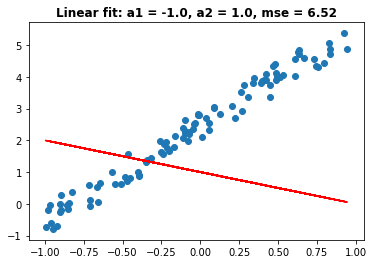

In [4]:
# Mean squared error function
def mse(y_hat,y): return ((y_hat-y)**2).mean()

# We start off with some random value for the cofficient.
w_test = torch.tensor([-1.,1.])
y_test = x@w_test
mse_test = mse(y_test,y)

plt.scatter(x[:,0], y)
plt.plot(x[:,0], y_test, c='r')
titlestring = f"Linear fit: a1 = {w_test[0]}, a2 = {w_test[1]}, mse = {np.round(mse_test.item(),2)}"
plt.title(titlestring, fontweight='bold')

Ok, so that was a terrible fit, as may be expected from randomly picking weights. We want to iterate on the weights so that the loss function is minimized. But what does the loss function actually look like? Well, we can plug in a whole range of values of $w_1$ and $w_2$ to take a look!

**Note**: This part of the SGD took inspiration from José Fernández Portal's (twitter: joshfp) example for the *fast.ai* course. 


Text(0.5, 0.92, 'MSE Loss Function')

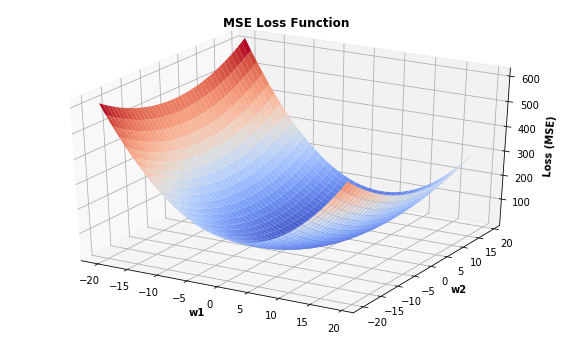

In [13]:
w1_test = np.arange(-20,20,1)
w2_test = np.arange(-20,20,1)

w1_grid, w2_grid = np.meshgrid(w1_test, w2_test)

loss_array = np.zeros(np.shape(w1_grid))

for w1_val in w1_test:
    for w2_val in w2_test:
        
        # Find the corresponding index value and place it in the loss array
        # w1 will be the row, w2 will be the column
        row = np.where(w1_test == w1_val)[0][0]
        column = np.where(w2_test == w2_val)[0][0]
        w_test = torch.tensor([float(w1_val),float(w2_val)])
        y_test = x@w_test
        mse_test = mse(y_test,y)
        loss_array[row,column] = mse_test.data.item()

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
ax.plot_surface(w1_grid, w2_grid, loss_array, cmap='coolwarm')
plt.xlabel('w1', fontweight='bold')
plt.ylabel('w2', fontweight='bold')
ax.set_zlabel('Loss (MSE)', fontweight='bold')
plt.title('MSE Loss Function', fontweight='bold')

Now, we are finally ready to do some SGD! We will use the easy-to-use *fastai* library to run several iterations and compute SGD. The gradient is calculated by variable .backward(), and placed into .grad

In [6]:
# Start off by setting a random set of weights (w) 
w = tensor([-20., 20.])

# Tell PyTorch that these are the coefficients that we want to change
w = nn.Parameter(w)

def update():
    y_hat = x@w
    loss = mse(y, y_hat)
    if t % 10 == 0: 
        print(loss)
        # print(w)
    loss.backward()
    with torch.no_grad():
        w.sub_(lr * w.grad)
        w.grad.zero_()
    return loss, w
        
lr = 1e-1
losses, w1_combined, w2_combined = [], [], []
for t in range(100): 
    loss_iter, weight_iter = update() 
    losses.append(loss_iter)
    w1_combined.append(weight_iter[0].data.item())
    w2_combined.append(weight_iter[1].data.item())

tensor(505.7195, grad_fn=<MeanBackward1>)
tensor(45.4852, grad_fn=<MeanBackward1>)
tensor(12.4358, grad_fn=<MeanBackward1>)
tensor(3.7511, grad_fn=<MeanBackward1>)
tensor(1.1720, grad_fn=<MeanBackward1>)
tensor(0.4023, grad_fn=<MeanBackward1>)
tensor(0.1726, grad_fn=<MeanBackward1>)
tensor(0.1040, grad_fn=<MeanBackward1>)
tensor(0.0835, grad_fn=<MeanBackward1>)
tensor(0.0774, grad_fn=<MeanBackward1>)


Now let's plot our best results!

Text(0.5, 1.0, 'Linear fit: w1 = 2.986530065536499, w2 = 2.4881200790405273, mse = 0.07568')

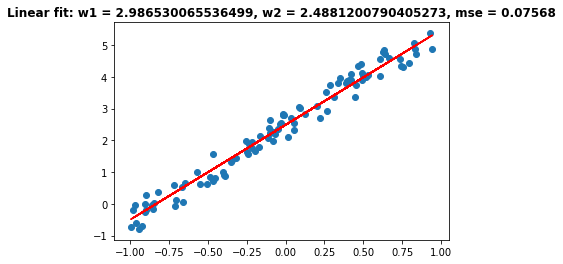

In [7]:
plt.scatter(x[:,0], y)
plt.plot(x[:,0],x@w, c='r')
titlestring = f"Linear fit: w1 = {np.round(w[0],5)}, w2 = {np.round(w[1],5)}, mse = {np.round(losses[-1].data.item(),5)}"
plt.title(titlestring, fontweight='bold')

And now, plot the best SGD path. We can clearly see how the MSE Loss function changes for each iteration. The rate at which the loss function is changed is called the **learning rate**. The learning rate is an important parameter that needs to be adapted to each dataset. It's out of scope of this initial tutorial, but you can recalculate with different values to see how the path down the loss function changes. 

Text(0.5, 0.92, 'MSE Loss Function')

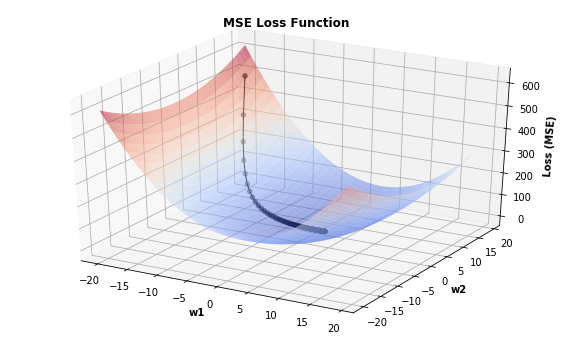

In [12]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
ax.plot(w1_combined, w2_combined, losses, c='black', linewidth=1.0, zorder=3)
ax.scatter(w1_combined, w2_combined, losses, c='black', linewidth=1.0, zorder=2)
ax.plot_surface(w1_grid, w2_grid, loss_array, cmap='coolwarm', zorder=-1, alpha=0.5)
plt.xlabel('w1', fontweight='bold')
plt.ylabel('w2', fontweight='bold')
ax.set_zlabel('Loss (MSE)', fontweight='bold')
plt.title('MSE Loss Function', fontweight='bold')